# Run MISTY on visium data

## Environment

In [1]:
# Not installed by default in the docker image
remotes::install_github("satijalab/seurat", "seurat5", quiet = TRUE)
install.packages("hdf5r")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(Seurat)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, saveRDS


Loading Seurat v5 beta version 
To maintain compatibility with previous workflows, new Seurat objects will use the previous object structure by default
To use new Seurat v5 assays: Please run: options(Seurat.object.assay.version = 'v5')



In [3]:
library(mistyR)

mistyR is able to run computationally intensive functions
  in parallel. Please consider specifying a future::plan(). For example by running
  future::plan(future::multisession) before calling mistyR functions.



## Load and preprocess data

In [4]:
filtered_data = Read10X_h5("data/CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5")

In [5]:
scaled_data = LogNormalize(filtered_data)

In [6]:
seurat_data = CreateSeuratObject(counts = scaled_data)

In [7]:
seurat_data = FindVariableFeatures(
  seurat_data, 
  selection.method = "vst", 
  nfeatures=500
)

Warning message:
“The following arguments are not used: nselect”


In [8]:
seurat_data = ScaleData(seurat_data,features=rownames(seurat_data))

Centering and scaling data matrix



In [9]:
seurat_data <- RunPCA(seurat_data, npcs = 40)

PC_ 1 
Positive:  DCN, CXCL12, C1R, COL14A1, IGFBP4, FSTL1, CCDC80, C1S, RNASE1, COL3A1 
	   SFRP2, MMP2, SERPING1, C3, PLTP, COL1A2, F13A1, EFEMP1, TNXB, COL6A3 
	   SERPINF1, COL1A1, FBLN1, SRPX, NID1, THBS2, MGP, OGN, CTSK, FBLN5 
Negative:  ANKRD30A, ERBB2, EPCAM, MLPH, KRT7, FXYD3, CRIP1, MIEN1, MUC1, FOXA1 
	   ELF3, MAL2, CD9, SLC12A2, PGAP3, CYB561, SCD, VMP1, PPM1D, CXCL17 
	   SREBF1, PERP, GRB7, STARD10, STARD3, KRT8, HMGN1, ALDH3B2, FASN, CCDC47 
PC_ 2 
Positive:  JCHAIN, IGHA1, IGKC, COMP, BGN, CTHRC1, MZB1, LYZ, TRAC, PIM2 
	   CXCL14, KRT17, KRT14, AEBP1, MMP11, CD52, KRT5, VCAN, IL7R, TRBC2 
	   IGHG1, LTB, COL17A1, POSTN, CTSK, MGP, CEACAM6, KRT6B, CRISPLD2, MMP7 
Negative:  FABP4, PLIN1, PLIN4, ADIPOQ, GPX3, ADH1B, CFD, G0S2, LPL, PPP1R1A 
	   LIPE, GPD1, SLC19A3, CD36, GPC3, RBP4, CIDEA, FHL1, TRARG1, MAOA 
	   CIDEC, GYG2, MARC1, GHR, AQP7, TNXB, DLK1, TMEM37, LYVE1, TAT 
PC_ 3 
Positive:  CEACAM6, KRT14, KRT15, KRT17, KRT23, SERPINA3, KRT5, TSPAN1, GABRP, MUC16 
	 

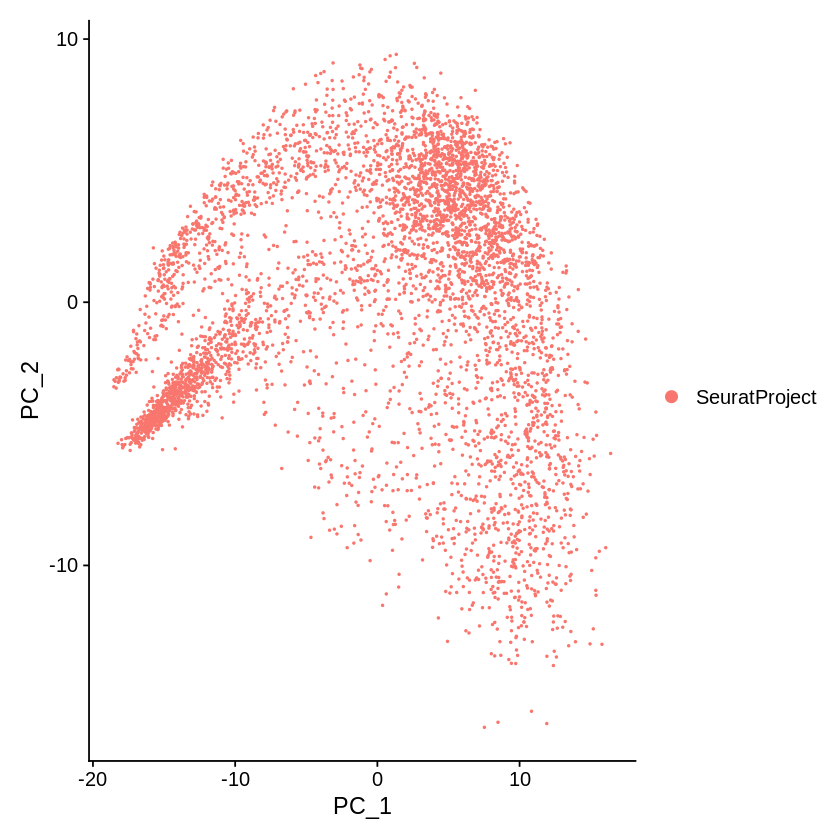

In [10]:
DimPlot(seurat_data,reduction="pca")

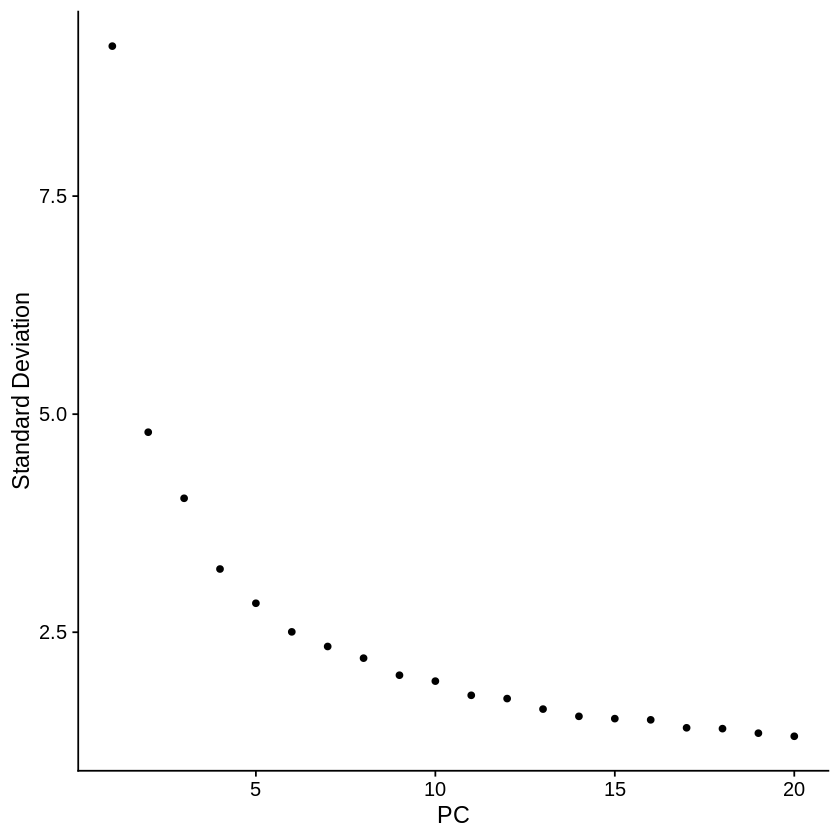

In [11]:
ElbowPlot(seurat_data)

## Format PCA table for MISTy

In [12]:
pca_table <- Embeddings(seurat_data, reduction = "pca")

In [13]:
# Filter cell barcodes to limit to region shared with Xenium
spots <- read.csv("data/spots.csv")$spot_name

In [14]:
pca_table <- data.frame(pca_table[row.names(pca_table) %in% spots,])

In [15]:
# Add spatial coordinates
coord = read.csv("data/spatial/tissue_positions.csv")

map_pos <- function(barcode){
    return(coord[coord$barcode == barcode, 
          c("pxl_row_in_fullres", "pxl_col_in_fullres")])
}

In [16]:
all_pos <- data.frame(t(sapply(rownames(pca_table), map_pos)))
colnames(all_pos) <- c("x", "y")
all_pos$x = as.numeric(all_pos$x)
all_pos$y = as.numeric(all_pos$y)

## Choosing a scale for the juxta and paraview

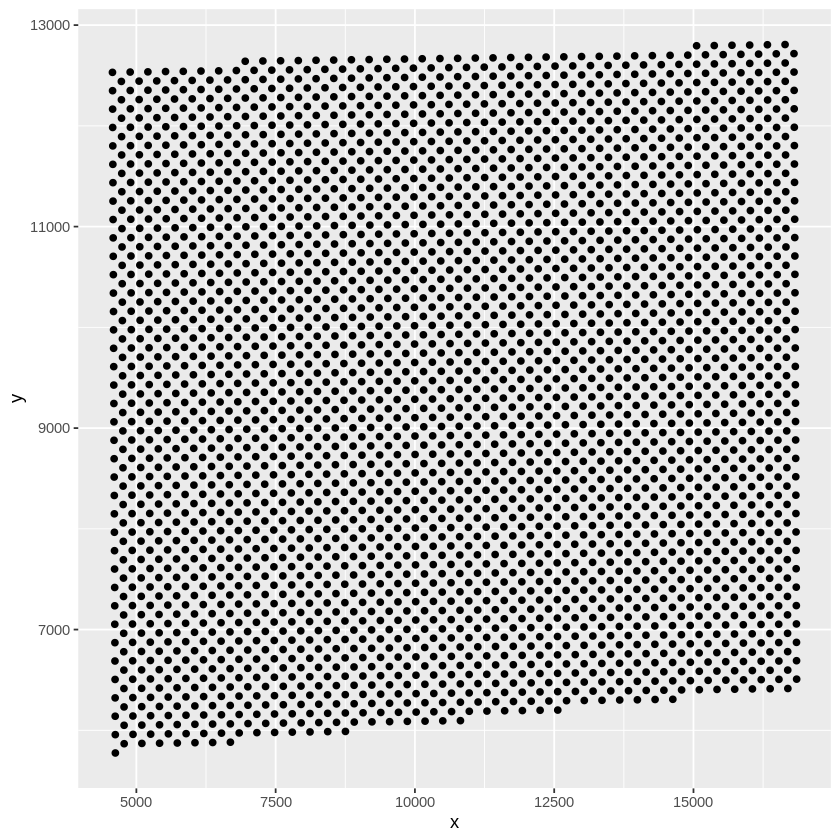

In [17]:
ggplot(all_pos, aes(x = x, y = y)) +
        geom_point()

In [18]:
all_pos[(all_pos$x < 5000)&(all_pos$y < 6000),]

x    y   
AACCAAGCGTGGCCTC-1 4623 5775
AAGCAGCCTACTAAGC-1 4940 5960
ATCATTCCACTTAGCA-1 4781 5867
CTAGATACAGACCGAG-1 4622 5957

In [19]:
sqrt((4622 - 4781)**2 + (5957 - 5867)**2)

[1] 182.7047

In [20]:
sqrt((4623 - 4622)**2 + (5957 - 5775)**2)

[1] 182.0027

In [21]:
table(dist(x = all_pos) < 183)


  FALSE    TRUE 
3997029    3177 

## MISTy
### Whole-slide MISTy

In [22]:
future::plan(future::multisession)

In [23]:
pca_table %>% 
    create_initial_view %>% 
    add_paraview(all_pos, l = 600, zoi = 200) %>%
    run_misty(results.folder = "data/misty/")


Generating paraview


Training models

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_24”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_26”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_29”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_31”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_32”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_33”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_34”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_35”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_38”
Warnin

[1] "/home/jovyan/data/misty"

In [24]:
misty.results <- collect_results("data/misty/")








Aggregating



Warning message:
“Removed 40 rows containing missing values (`geom_segment()`).”
Warning message:
“Removed 40 rows containing missing values (`geom_segment()`).”


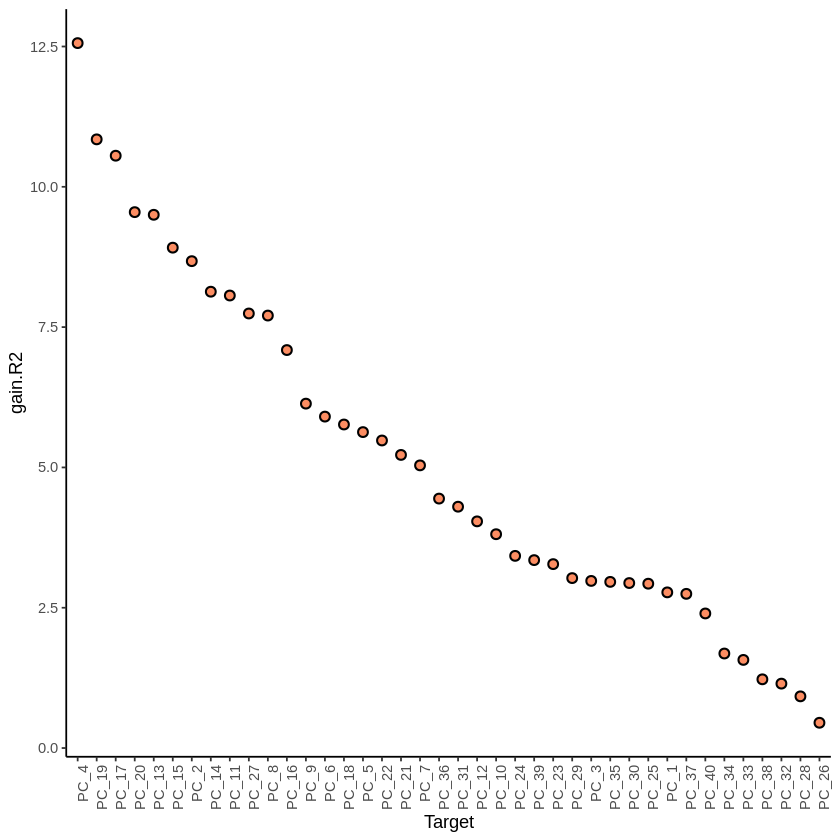

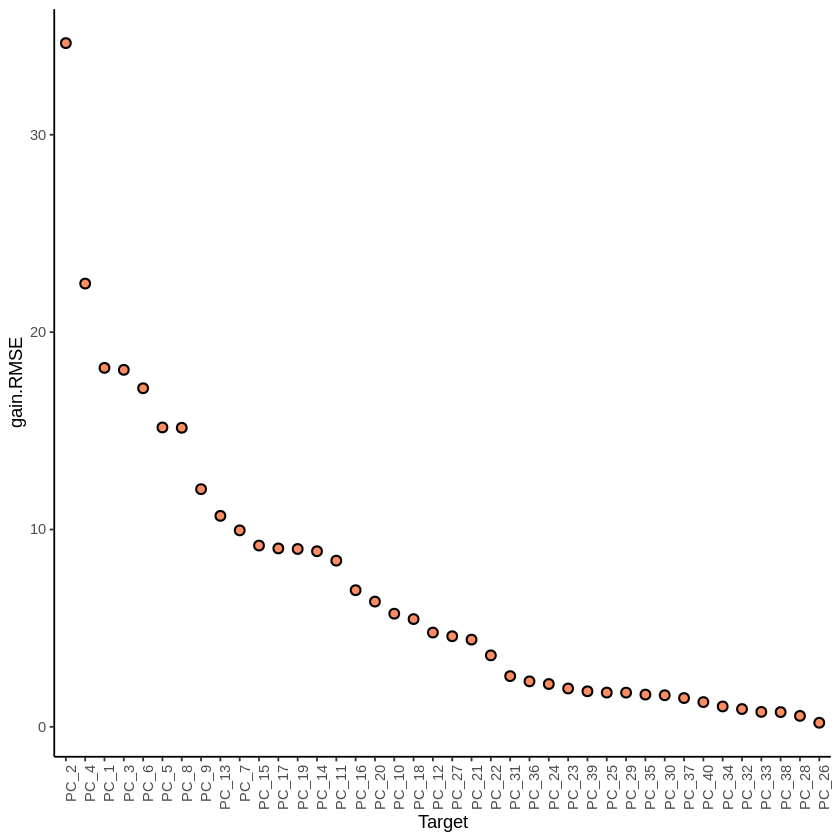

In [25]:
misty.results %>%
  plot_improvement_stats("gain.R2") %>%
  plot_improvement_stats("gain.RMSE")

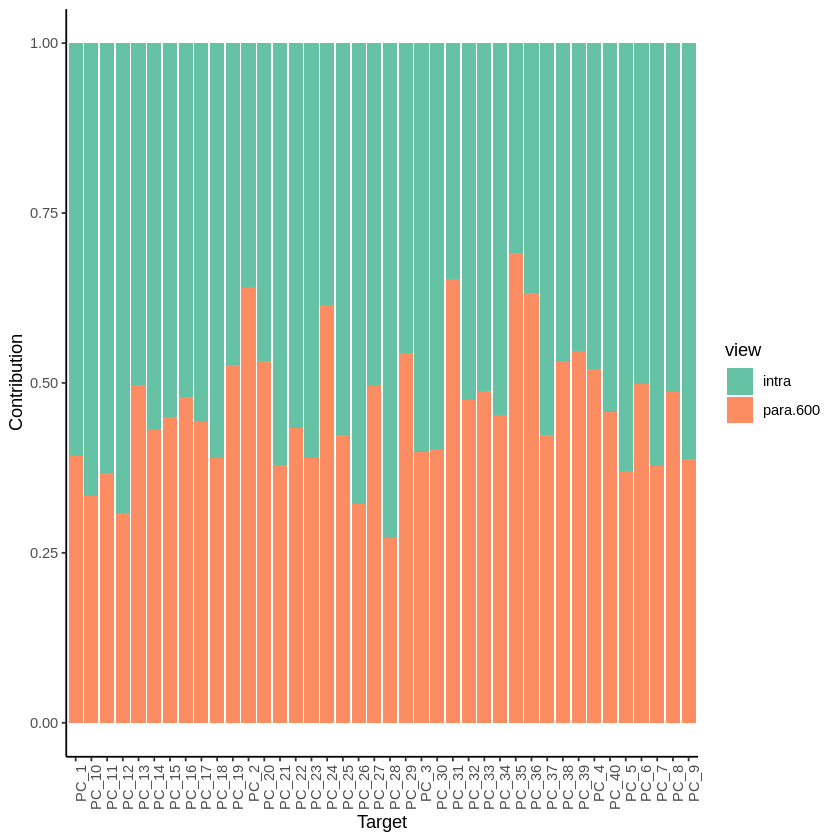

In [26]:
misty.results %>% plot_view_contributions()

### Sliding MISTy

In [29]:
# Try 10x10 spots per window, with half-window stride.
pca_table %>% 
    create_initial_view %>% 
    add_paraview(all_pos, l = 600, zoi = 200) %>%
    run_sliding_misty(., all_pos,
                      minu = 90, window = 2000,
                      results.folder = "data/sliding_misty/")


Sliding


Generating paraview

Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_10”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_11”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_12”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_13”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_14”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_15”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_18”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_20”
Warning message in ...furrr_fn(...):
“Negative performance detected and replaced with 0 for target PC_22”
Warning messag

[1] "data/sliding_misty//10571_10775_12571_12775"
 [2] "data/sliding_misty//10571_5775_12571_7775"  
 [3] "data/sliding_misty//10571_6775_12571_8775"  
 [4] "data/sliding_misty//10571_7775_12571_9775"  
 [5] "data/sliding_misty//10571_8775_12571_10775" 
 [6] "data/sliding_misty//10571_9775_12571_11775" 
 [7] "data/sliding_misty//11571_10775_13571_12775"
 [8] "data/sliding_misty//11571_5775_13571_7775"  
 [9] "data/sliding_misty//11571_6775_13571_8775"  
[10] "data/sliding_misty//11571_7775_13571_9775"  
[11] "data/sliding_misty//11571_8775_13571_10775" 
[12] "data/sliding_misty//11571_9775_13571_11775" 
[13] "data/sliding_misty//12571_10775_14571_12775"
[14] "data/sliding_misty//12571_5775_14571_7775"  
[15] "data/sliding_misty//12571_6775_14571_8775"  
[16] "data/sliding_misty//12571_7775_14571_9775"  
[17] "data/sliding_misty//12571_8775_14571_10775" 
[18] "data/sliding_misty//12571_9775_14571_11775" 
[19] "data/sliding_misty//13571_10775_15571_12775"
[20] "data/sliding_misty//13571_5775_15571_7775"  
[21] "data/sliding_misty//13571_6775_15571_8775"  
[22] "data/sliding_misty//13571_7775_15571_9775"  
[23] "data/sliding_misty//13571_8775_15571_10775" 
[24] "data/sliding_misty//13571_9775_15571_11775" 
[25] "data/sliding_misty//14571_10775_16571_12775"
[26] "data/sliding_misty//14571_5775_16571_7775"  
[27] "data/sliding_misty//14571_6775_16571_8775"  
[28] "data/sliding_misty//14571_7775_16571_9775"  
[29] "data/sliding_misty//14571_8775_16571_10775" 
[30] "data/sliding_misty//14571_9775_16571_11775" 
[31] "data/sliding_misty//15571_6775_16852_8775"  
[32] "data/sliding_misty//4571_10775_6571_12775"  
[33] "data/sliding_misty//4571_5775_6571_7775"    
[34] "data/sliding_misty//4571_6775_6571_8775"    
[35] "data/sliding_misty//4571_7775_6571_9775"    
[36] "data/sliding_misty//4571_8775_6571_10775"   
[37] "data/sliding_misty//4571_9775_6571_11775"   
[38] "data/sliding_misty//5571_10775_7571_12775"  
[39] "data/sliding_misty//5571_5775_7571_7775"    
[40] "data/sliding_misty//5571_6775_7571_8775"    
[41] "data/sliding_misty//5571_7775_7571_9775"    
[42] "data/sliding_misty//5571_8775_7571_10775"   
[43] "data/sliding_misty//5571_9775_7571_11775"   
[44] "data/sliding_misty//6571_10775_8571_12775"  
[45] "data/sliding_misty//6571_5775_8571_7775"    
[46] "data/sliding_misty//6571_6775_8571_8775"    
[47] "data/sliding_misty//6571_7775_8571_9775"    
[48] "data/sliding_misty//6571_8775_8571_10775"   
[49] "data/sliding_misty//6571_9775_8571_11775"   
[50] "data/sliding_misty//7571_10775_9571_12775"  
[51] "data/sliding_misty//7571_5775_9571_7775"    
[52] "data/sliding_misty//7571_6775_9571_8775"    
[53] "data/sliding_misty//7571_7775_9571_9775"    
[54] "data/sliding_misty//7571_8775_9571_10775"   
[55] "data/sliding_misty//7571_9775_9571_11775"   
[56] "data/sliding_misty//8571_10775_10571_12775" 
[57] "data/sliding_misty//8571_5775_10571_7775"   
[58] "data/sliding_misty//8571_6775_10571_8775"   
[59] "data/sliding_misty//8571_7775_10571_9775"   
[60] "data/sliding_misty//8571_8775_10571_10775"  
[61] "data/sliding_misty//8571_9775_10571_11775"  
[62] "data/sliding_misty//9571_10775_11571_12775" 
[63] "data/sliding_misty//9571_5775_11571_7775"   
[64] "data/sliding_misty//9571_6775_11571_8775"   
[65] "data/sliding_misty//9571_7775_11571_9775"   
[66] "data/sliding_misty//9571_8775_11571_10775"  
[67] "data/sliding_misty//9571_9775_11571_11775"

In [35]:
sm.results <- collect_results(list.dirs("./data/sliding_misty")[-1])








Aggregating



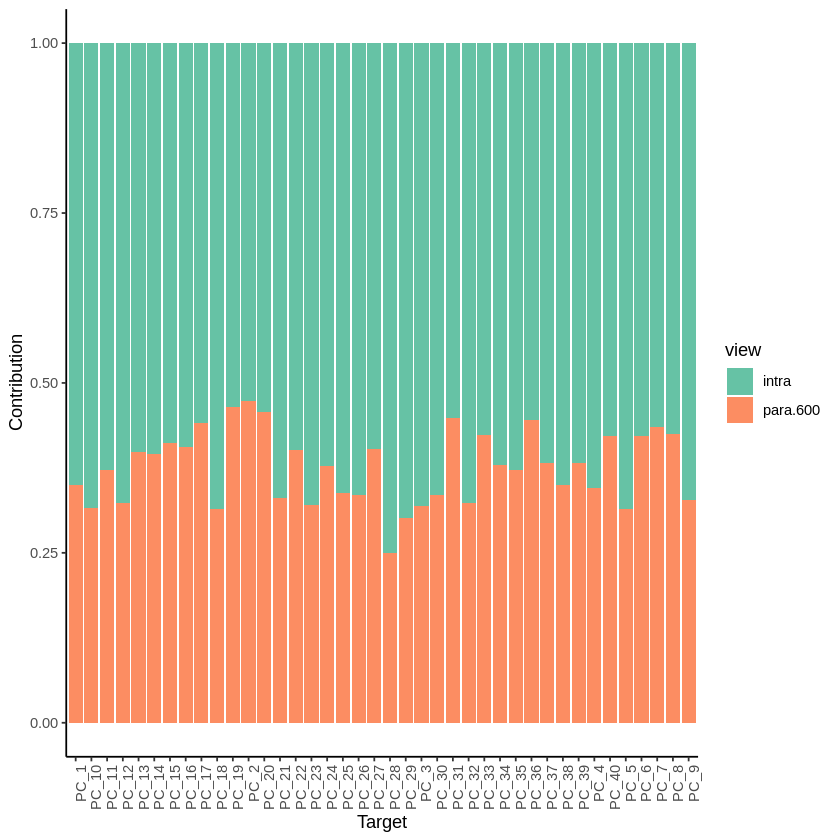

In [36]:
sm.results %>% plot_view_contributions()

In [39]:
head(sm.results$importances)

sample                                                  view  Predictor
1 /home/jovyan/data/sliding_misty/10571_10775_12571_12775 intra PC_1     
2 /home/jovyan/data/sliding_misty/10571_10775_12571_12775 intra PC_1     
3 /home/jovyan/data/sliding_misty/10571_10775_12571_12775 intra PC_1     
4 /home/jovyan/data/sliding_misty/10571_10775_12571_12775 intra PC_1     
5 /home/jovyan/data/sliding_misty/10571_10775_12571_12775 intra PC_1     
6 /home/jovyan/data/sliding_misty/10571_10775_12571_12775 intra PC_1     
  Target Importance 
1 PC_1            NA
2 PC_10   0.60730665
3 PC_11  -0.31717338
4 PC_12   0.00518380
5 PC_13   0.53786688
6 PC_14  -0.07795533